Objective:
- Build adhesome network (threshold, inter/inter+intra) and perform WCC, HC, sanity checks and robustness analysis
- Similar for adhesome and adhesome+adhesome TFs network

### Setup

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from pyvis.network import Network
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures2/correlation_clustering.py'>

In [2]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load data

In [4]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [5]:
# Adhesome genes and loci
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_genes_loci.pkl', 'rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl', 'rb'))

In [6]:
# Adhesome TF genes and loci
active_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'active_lung_adhesome_tf_genes.pkl','rb'))
active_lung_adhesome_tf_loci = pickle.load(open(saving_dir+'active_lung_adhesome_tf_loci.pkl','rb'))

In [7]:
# Selected genes = Adhesome genes + adhesome TFs
selected_genes = np.unique(np.concatenate([active_adhesome_genes,active_lung_adhesome_tf_genes], axis=0))
selected_loci = np.unique(np.concatenate([active_adhesome_loci,active_lung_adhesome_tf_loci], axis=0))
selected_gene2locus = pickle.load(open(saving_dir+'adh_and_tf_gene2locus.pkl','rb'))
selected_locus2gene = pickle.load(open(saving_dir+'adh_and_tf_locus2gene.pkl','rb'))
adh_and_tf_chr_loci = pickle.load(open(saving_dir+'adh_and_tf_chr_loci.pkl','rb'))
contacts_df = pickle.load(open(saving_dir+'contacts_df.pkl','rb')).loc[selected_loci,selected_loci]

# Network of adhesome genes and adhesome TF genes

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

### Network of adhesome genes: interX and intraX

In [8]:
# Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))

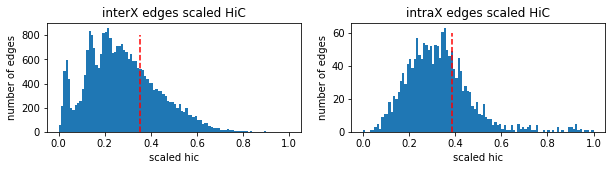

In [9]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(adhesome_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(adhesome_interX_edge_list['scaled_hic'],0.72), ymin=0, ymax=800, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(adhesome_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.72), ymin=0, ymax=60, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

### Genomic features for each adhesome gene

In [10]:
# Load epigenomic features
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
# Restrict to genes in cluster
df_cluster_norm = df_all_norm[selected_genes]
# Compute gene Spearman correlation matrix
adhesome_loc_corr = df_cluster_norm.corr(method='spearman')

In [11]:
# Add Spearman correlation to interX edge list
adhesome_interX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                    adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
# Add Spearman correlation to intraX edge list
adhesome_intraX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                    adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]

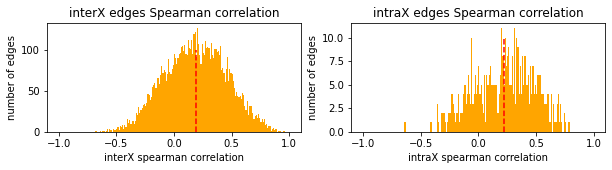

interX test:
Ttest_1sampResult(statistic=61.991558272440265, pvalue=0.0)
KstestResult(statistic=0.27274116380250935, pvalue=0.0)
intraX test:
Ttest_1sampResult(statistic=18.259730402891176, pvalue=1.3090754318868136e-56)
KstestResult(statistic=0.35614236586916637, pvalue=1.2576719813518743e-53)


In [12]:
# Plot distribution of Spearman correlation in selected edges
hic_threshold = 0.72
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u]
[['source','target','hic','scaled_hic','spearman_corr']]
plt.figure(figsize=(10,2))
# interX
plt.subplot(1, 2, 1)
plt.hist(inter_selected['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(inter_selected['spearman_corr']), ymin=0, ymax=100, color='red', linestyle='dashed')
plt.xlabel('interX spearman correlation')
plt.ylabel('number of edges')
plt.title('interX edges Spearman correlation')

# intraX
plt.subplot(1, 2, 2)
plt.hist(intra_selected['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(intra_selected['spearman_corr']), ymin=0, ymax=10, color='red', linestyle='dashed')
plt.xlabel('intraX spearman correlation')
plt.ylabel('number of edges')
plt.title('intraX edges Spearman correlation')

plt.show()
# Run statistical tests
print('interX test:')
print(ss.ttest_1samp(inter_selected['spearman_corr'], popmean=0))
print(ss.kstest(inter_selected['spearman_corr']/np.std(inter_selected['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided'))
print('intraX test:')
print(ss.ttest_1samp(intra_selected['spearman_corr'], popmean=0))
print(ss.kstest(intra_selected['spearman_corr']/np.std(intra_selected['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided'))

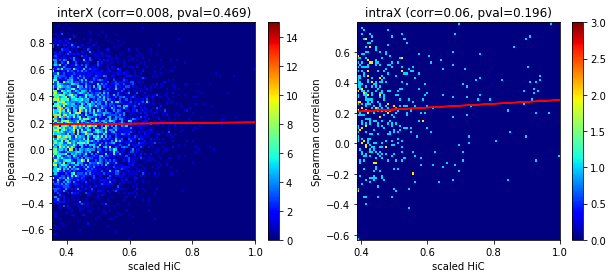

In [13]:
# Plot relationship between HiC and Spearman correlation
hic_threshold = 0.72
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# InterX edges
x = inter_selected['scaled_hic']
y = inter_selected['spearman_corr']
h1 = ax1.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x+b, color='red')
ax1.set_xlabel('scaled HiC')
ax1.set_ylabel('Spearman correlation')
fig.colorbar(h1[3], ax=ax1)
pearson = ss.pearsonr(x,y)
ax1.set_title('interX (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')
# IntraX edges
x = intra_selected['scaled_hic']
y = intra_selected['spearman_corr']
h2 = ax2.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax2.plot(x, m*x+b, color='red')
ax2.set_xlabel('scaled HiC')
ax2.set_ylabel('Spearman correlation')
fig.colorbar(h2[3], ax=ax2)
pearson = ss.pearsonr(x,y)
ax2.set_title('intraX (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')
plt.show()

# Clustering analysis

In [14]:
# Parameters
hic_threshold = 0.72
with_intra = True
weights = 'spearman_corr'

In [15]:
# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G.add_nodes_from(active_adhesome_genes)

### Clustering with VOTE+BOEM

Objective value after vote =  1508.52
Objective value after boem =  1485.91
Number of clusters =  143
Number of singletons = 87
Number of nodes in non trivial clusters = 164
Size of clusters


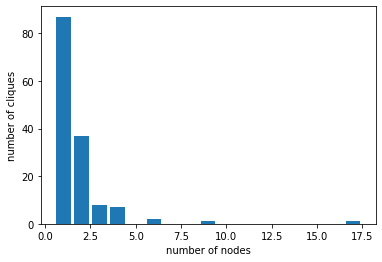

In [16]:
# Run WCC
wcc = cc.weighted_correlation_clustering_micha(adhesome_interX_edge_list, 
                                               adhesome_intraX_edge_list,
                                               selected_genes,
                                               hic_threshold,
                                               with_intra,
                                               weights,
                                               num_calls=100,
                                               seed=13)
clustering_graph2_wcc, vote_objective, boem_objective, num_clusters = wcc
print('Objective value after vote = ', vote_objective)
print('Objective value after boem = ', boem_objective)
print('Number of clusters = ', num_clusters)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_wcc, return_counts=True)[1],return_counts=True)
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_wcc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [17]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_wcc[i]) for i in range(n)}, "wcc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_and_tf_chr_loci[adh_and_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_wcc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_wcc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_intra.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_wcc_nointra.html")

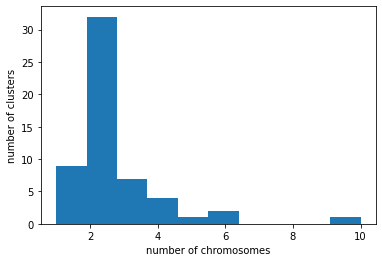

In [18]:
# Plot number of chromosomes per cluster
plt.figure()
oi.get_networkx_graph_as_dataframe_of_nodes(cG).groupby('wcc_cluster')['chromosome'].nunique().plot.hist()
plt.xlabel('number of chromosomes')
plt.ylabel('number of clusters')
plt.show()

### Clustering with hierarchical clustering

In [19]:
# Perform HC with various thresholds
threshold_list = np.arange(0,2,0.01)
n_clusters = []
for hc_threshold in tqdm(threshold_list):
    clustering_graph2_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                      adhesome_intraX_edge_list,
                                                      selected_genes,
                                                      hic_threshold,
                                                      with_intra,
                                                      weights,
                                                      hc_threshold,
                                                      plot=False)
    n_clusters.append(len(np.unique(clustering_graph2_hc)))
n_clusters = np.array(n_clusters)

100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Threshold of largest drop = 0.995


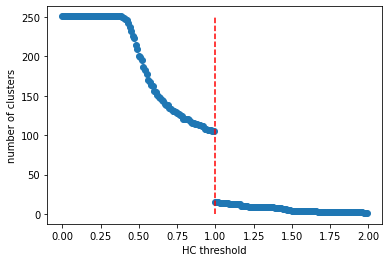

In [20]:
# Plot number of clusters as a function of HC threshold
t_critic = (threshold_list[np.where(n_clusters>50)[0][-1]]+threshold_list[np.where(n_clusters<50)[0][0]])/2
print('Threshold of largest drop = '+str(t_critic))
plt.figure()
plt.scatter(threshold_list, n_clusters)
plt.vlines(x=t_critic, ymin=0, ymax=250, color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('number of clusters')
plt.show()

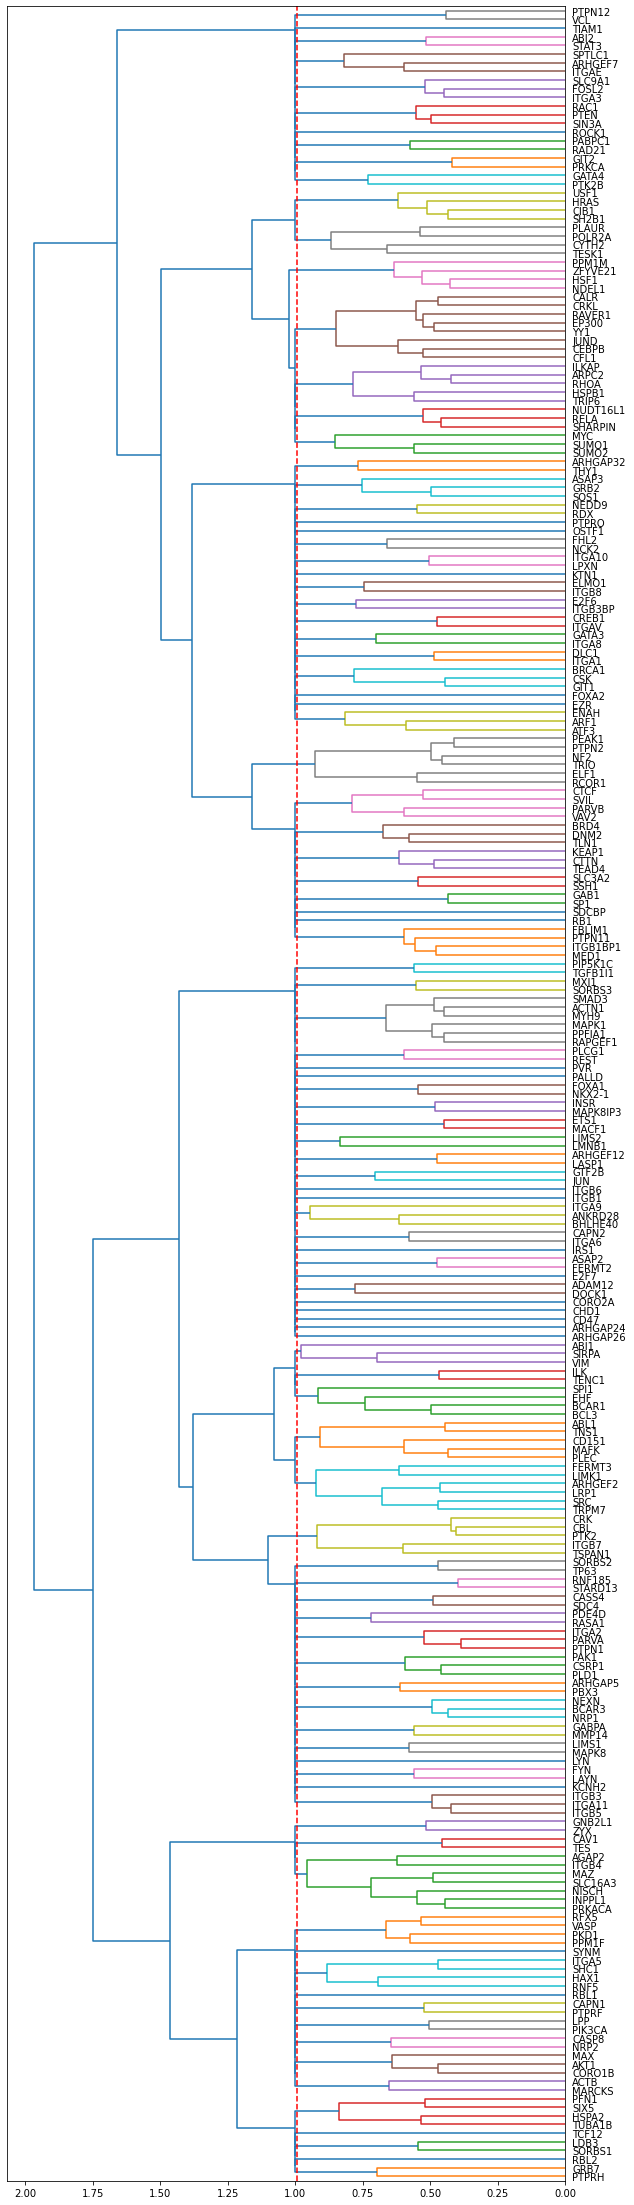

Number of clusters = 105
Number of singletons = 26
Number of nodes in non trivial clusters = 225
Size of clusters


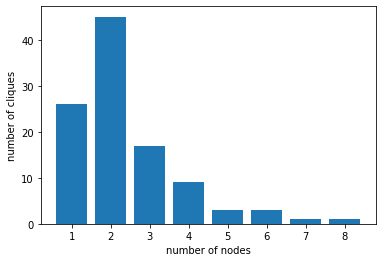

In [21]:
#Run HC
hc_threshold = t_critic
clustering_graph2_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  selected_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [22]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_and_tf_chr_loci[adh_and_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra.html")

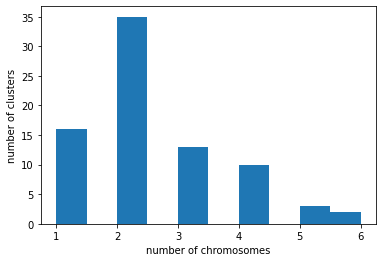

In [23]:
# Plot number of chromosomes per cluster
plt.figure()
oi.get_networkx_graph_as_dataframe_of_nodes(cG).groupby('hc_cluster')['chromosome'].nunique().plot.hist()
plt.xlabel('number of chromosomes')
plt.ylabel('number of clusters')
plt.show()

### Sanity checks

In [24]:
# Produce a random clustering for comparison with same number of clusters as WCC
np.random.seed(14)
clustering_graph2_random = np.random.permutation(clustering_graph2_wcc)

In [25]:
# Strongest edges (Spearman correlation)
adhesome_edge_list_sorted = adhesome_edge_list.sort_values(by='spearman_corr', ascending=False)
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr
17210,PARVA,PTPN1,1.956734,0.399427,0.952019
23986,STARD13,RNF185,1.845927,0.368980,0.920213
5099,CRK,PTPN1,2.833272,0.640278,0.911420
3909,CBL,PTK2,1.990875,0.408808,0.906318
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933


In [26]:
# Check whether these edges are clustered together in WCC
adhesome_edge_list_sorted['coclustered_wcc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,5] = (clustering_graph2_wcc[index_gene1]==clustering_graph2_wcc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc
17210,PARVA,PTPN1,1.956734,0.399427,0.952019,False
23986,STARD13,RNF185,1.845927,0.368980,0.920213,False
5099,CRK,PTPN1,2.833272,0.640278,0.911420,True
3909,CBL,PTK2,1.990875,0.408808,0.906318,True
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933,True


In [27]:
# Check whether these edges are clustered together in HC
adhesome_edge_list_sorted['coclustered_hc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,6] = (clustering_graph2_hc[index_gene1]==clustering_graph2_hc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc
17210,PARVA,PTPN1,1.956734,0.399427,0.952019,False,True
23986,STARD13,RNF185,1.845927,0.368980,0.920213,False,False
5099,CRK,PTPN1,2.833272,0.640278,0.911420,True,False
3909,CBL,PTK2,1.990875,0.408808,0.906318,True,True
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933,True,True


In [28]:
# Check whether these edges are clustered together in the random clustering
adhesome_edge_list_sorted['coclustered_random'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,7] = (clustering_graph2_random[index_gene1]==clustering_graph2_random[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random
17210,PARVA,PTPN1,1.956734,0.399427,0.952019,False,True,False
23986,STARD13,RNF185,1.845927,0.368980,0.920213,False,False,False
5099,CRK,PTPN1,2.833272,0.640278,0.911420,True,False,False
3909,CBL,PTK2,1.990875,0.408808,0.906318,True,True,False
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933,True,True,False


In [29]:
# Check whether these edges are clustered together in both WCC and HC
adhesome_edge_list_sorted['coclustered_wcc_hc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,8] = (adhesome_edge_list_sorted.iloc[i,5]==True) and (adhesome_edge_list_sorted.iloc[i,6]==True)
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc
17210,PARVA,PTPN1,1.956734,0.399427,0.952019,False,True,False,False
23986,STARD13,RNF185,1.845927,0.368980,0.920213,False,False,False,False
5099,CRK,PTPN1,2.833272,0.640278,0.911420,True,False,False,False
3909,CBL,PTK2,1.990875,0.408808,0.906318,True,True,False,True
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933,True,True,False,True


In [30]:
# Check whether WCC and HCC produce similar clusters
adhesome_edge_list_sorted['hc_wcc_match'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    adhesome_edge_list_sorted.iloc[i,9] = (adhesome_edge_list_sorted.iloc[i,5]==adhesome_edge_list_sorted.iloc[i,6])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc,hc_wcc_match
17210,PARVA,PTPN1,1.956734,0.399427,0.952019,False,True,False,False,False
23986,STARD13,RNF185,1.845927,0.368980,0.920213,False,False,False,False,True
5099,CRK,PTPN1,2.833272,0.640278,0.911420,True,False,False,False,False
3909,CBL,PTK2,1.990875,0.408808,0.906318,True,True,False,True,True
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933,True,True,False,True,True


In [31]:
# Compute cumsums
adhesome_edge_list_sorted['coclustered_wcc_cumsum'] = adhesome_edge_list_sorted['coclustered_wcc'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_hc_cumsum'] = adhesome_edge_list_sorted['coclustered_hc'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_random_cumsum'] = adhesome_edge_list_sorted['coclustered_random'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_wcc_hc_cumsum'] = adhesome_edge_list_sorted['coclustered_wcc_hc'].astype(int).cumsum()
adhesome_edge_list_sorted['hc_wcc_match_cumsum'] = adhesome_edge_list_sorted['hc_wcc_match'].astype(int).cumsum()
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,coclustered_random,coclustered_wcc_hc,hc_wcc_match,coclustered_wcc_cumsum,coclustered_hc_cumsum,coclustered_random_cumsum,coclustered_wcc_hc_cumsum,hc_wcc_match_cumsum
17210,PARVA,PTPN1,1.956734,0.399427,0.952019,False,True,False,False,False,0,1,0,0,0
23986,STARD13,RNF185,1.845927,0.368980,0.920213,False,False,False,False,True,0,1,0,0,1
5099,CRK,PTPN1,2.833272,0.640278,0.911420,True,False,False,False,False,1,1,0,0,1
3909,CBL,PTK2,1.990875,0.408808,0.906318,True,True,False,True,True,2,2,0,1,2
17519,PEAK1,PTPN2,1.908741,0.386240,0.884933,True,True,False,True,True,3,3,0,2,3


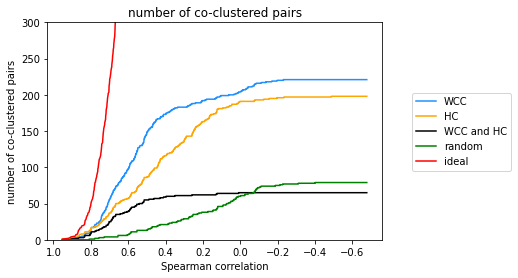

In [32]:
# Plot number of co-clustered pairs versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_wcc_cumsum'],
         color='dodgerblue', label='WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_hc_cumsum'],
         color='orange', label='HC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_wcc_hc_cumsum'],
         color='black', label='WCC and HC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_random_cumsum'],
         color='green', label='random')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend(loc='upper right', bbox_to_anchor=[1.4,0.7])
plt.xlabel('Spearman correlation')
plt.ylabel('number of co-clustered pairs')
plt.ylim([0,300])
plt.title('number of co-clustered pairs')
plt.show()

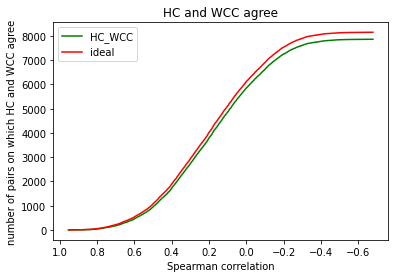

In [33]:
# Plot number of clustered pairs on which HC and WCC agree versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['hc_wcc_match_cumsum'],
         color='green', label='HC_WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of pairs on which HC and WCC agree')
plt.title('HC and WCC agree')
plt.show()

In [34]:
# Adjusted mutual information
adjusted_mutual_info_score(labels_true=clustering_graph2_wcc,
                           labels_pred=clustering_graph2_hc, 
                           average_method='min')

0.4902289785106596

### Robustness of WCC

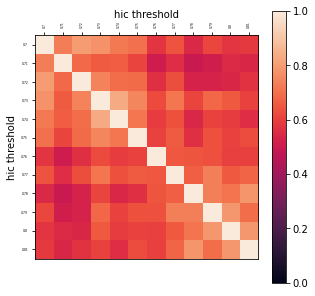

In [35]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_wcc.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_wcc.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 0, 1)

### Robustness of HC

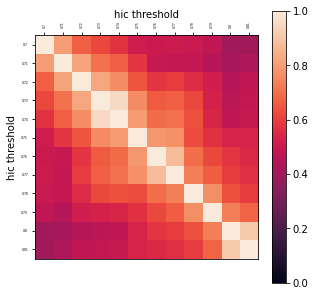

In [36]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_hc.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_hc.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 0, 1)

### AMI between HC and WCC

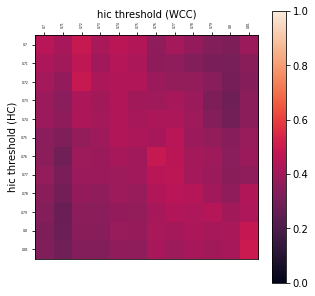

In [37]:
# Load HC and WCC clusterings
hc_dict = pickle.load(open(saving_dir+'dict_intra_hc.pickle','rb'))
wcc_dict = pickle.load(open(saving_dir+'dict_intra_wcc.pickle','rb'))
# hc_dict = pickle.load(open(saving_dir+'dict_nointra_hc.pickle','rb'))
# wcc_dict = pickle.load(open(saving_dir+'dict_nointra_wcc.pickle','rb'))
hic_threshold_list = hc_dict.keys()

# Fill in Adjusted Mutual Information between clusterings
ami_table = pd.DataFrame(1,index=hic_threshold_list, columns=hic_threshold_list)
for t,u in itertools.product(hic_threshold_list,hic_threshold_list):
    ami_table.loc[t,u] = adjusted_mutual_info_score(labels_true=hc_dict[t],labels_pred=wcc_dict[u],
                                                    average_method='min')
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold (WCC)', 'hic threshold (HC)', 5, 0, 1)

-----------------------------------------------------------------------------------------------------------------

# Final network and clustering

In [61]:
# Load gene to chromosome dict
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl','rb'))
# Load hTFtarget data set
active_lung_tf2target = pickle.load(open(saving_dir+'active_lung_tf2target.pkl', 'rb'))
active_lung_target2tf = pickle.load(open(saving_dir+'active_lung_target2tf.pkl', 'rb'))
# All genes
all_active_genes = pickle.load(open(saving_dir+'all_active_genes.pkl', 'rb'))
# Metadata
active_lung_tf_genes = pickle.load(open(saving_dir+'active_lung_tf_genes.pkl','rb'))
proteins_df = pickle.load(open(dir_proteins+'mechanoreg_proteins.pkl', 'rb'))
collagens = proteins_df[proteins_df['family']=='collagen']['geneSymbol'].values
lamins = proteins_df[proteins_df['family']=='lamin']['geneSymbol'].values
lims = proteins_df[proteins_df['family']=='LIM']['geneSymbol'].values
mmps = proteins_df[proteins_df['family']=='MMP']['geneSymbol'].values
elastin = proteins_df[proteins_df['family']=='elastin']['geneSymbol'].values
fibronectin = proteins_df[proteins_df['family']=='fibronectin']['geneSymbol'].values
tenascins = proteins_df[proteins_df['family']=='tenascin']['geneSymbol'].values

In [236]:
# Construct network
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])        
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
G.add_nodes_from(selected_genes)

# Get adjacency matrix of G
A = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_corr')
A = np.array(A.todense())
A = np.exp(-A)
# Select upper triangular entries and flatten
y = A[np.triu_indices(n=len(A),k=1)]

In [239]:
n = len(A)
n*(n-1)/2

31375.0

In [240]:
len(y)

31375

In [237]:
y

array([1.        , 1.        , 1.        , ..., 0.63042899, 1.        ,
       0.57755137])

In [ ]:
# Hierarchical clustering
linked = linkage(y, method='complete')

# Record flat clustering
clustering = fcluster(linked, t=hc_threshold, criterion='distance')

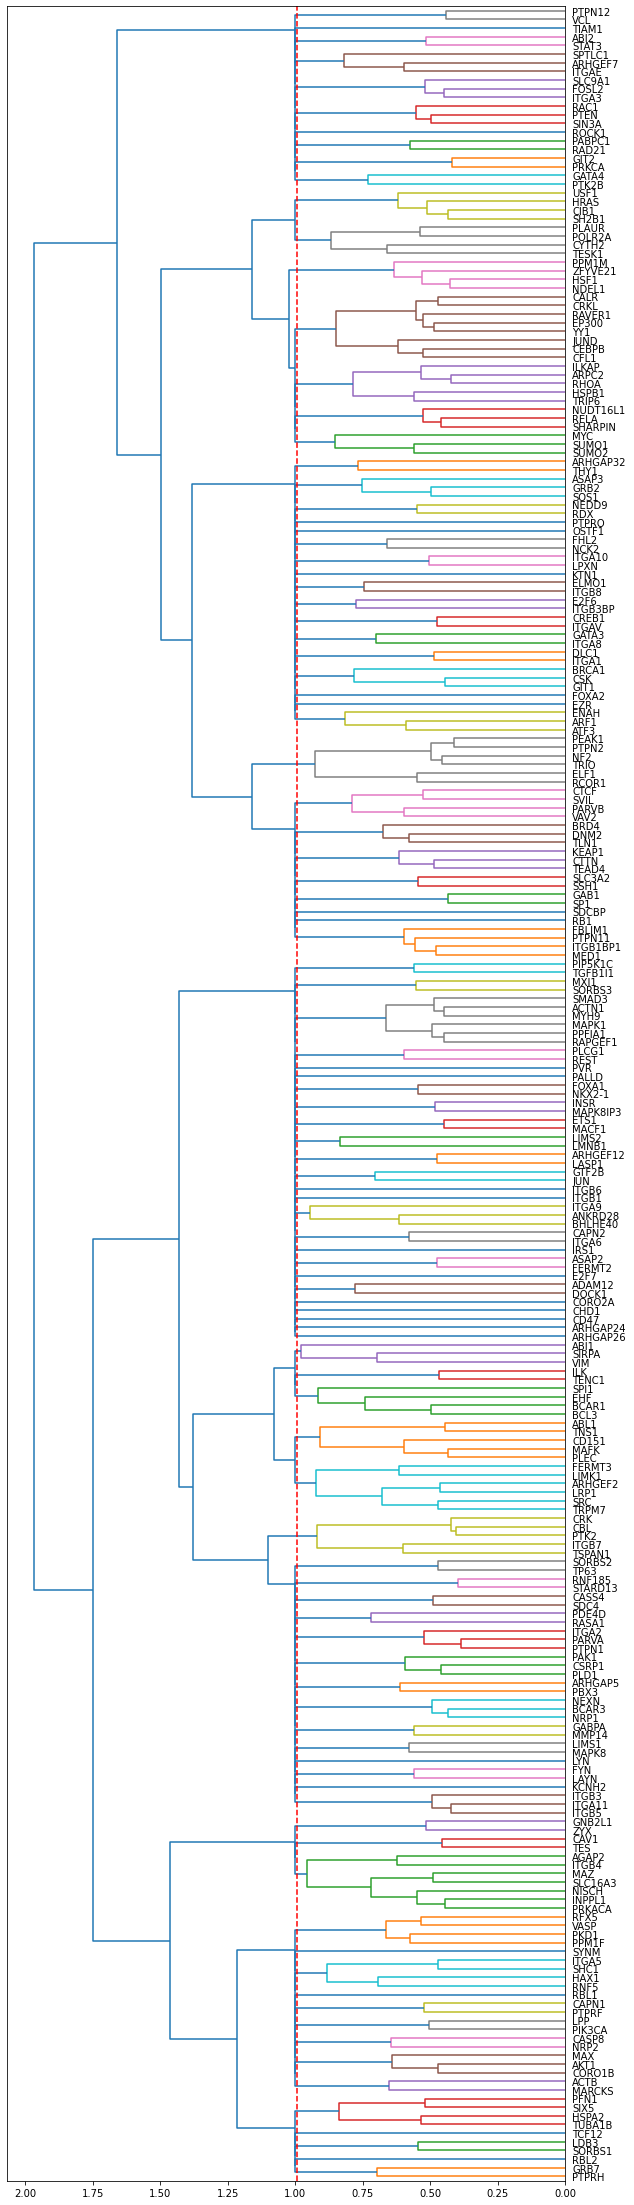

Number of clusters = 105
Number of singletons = 26
Number of nodes in non trivial clusters = 225
Size of clusters


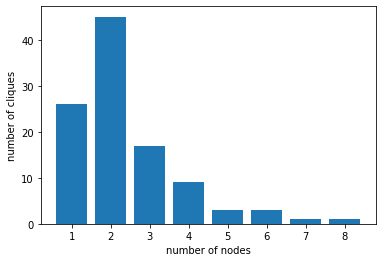

In [62]:
#Run HC
hc_threshold = 0.995
clustering_graph2_hc = cc.hierarchical_clustering(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  selected_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [63]:
# Create dataframe with cluster
clusters_df = pd.DataFrame({'genes': selected_genes, 'cluster': clustering_graph2_hc})
clusters_df = clusters_df.groupby(['cluster']).agg({'genes':lambda x : list(x)}). reset_index()
clusters_df['chromosomes'] = [[gene2chrom[g] for g in clusters_df.iloc[i]['genes']]
                                    for i in range(clusters_df.shape[0])]
clusters_df['n_chromosomes'] = [len(np.unique(clusters_df.iloc[i]['chromosomes'])) for i in range(clusters_df.shape[0])]

In [64]:
# Annotate adheosme genes and TF genes
clusters_df['adhesome_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in active_adhesome_genes]
                                      for i in range(clusters_df.shape[0])]
clusters_df['tf_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in active_lung_adhesome_tf_genes]
                                      for i in range(clusters_df.shape[0])]

In [65]:
# Cluster size
clusters_df['size_genes'] = [len(clusters_df.iloc[i]['genes']) for i in range(clusters_df.shape[0])]
clusters_df['size_tf_genes'] = [len(clusters_df.iloc[i]['tf_genes']) for i in range(clusters_df.shape[0])]
clusters_df = clusters_df.sort_values(by=['size_genes', 'size_tf_genes'], ascending=False)
# Only keep clusters with more than 2 genes
clusters_df = clusters_df[clusters_df['size_genes']>2]

In [66]:
# Specificity of TFs
clusters_df['prop_adhesome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(active_adhesome_genes)))/len(active_adhesome_genes),3) for tf in clusters_df.iloc[i]['tf_genes']]
                                              for i in range(clusters_df.shape[0])]
clusters_df['prop_genome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(all_active_genes)))/len(all_active_genes),3) for tf in clusters_df.iloc[i]['tf_genes']]
                                              for i in range(clusters_df.shape[0])]

In [223]:
# Print stats
print('Number of clusters = '+str(clusters_df.shape[0]))
print('Number of genes in clusters = '+str(len(np.unique(sorted(itertools.chain.from_iterable(clusters_df['genes']))))))
pickle.dump(clusters_df, open(saving_dir+'adhesome_clusters_df.pkl', 'wb'))
clusters_df

Number of clusters = 34
Number of genes in clusters = 135


,cluster,genes,chromosomes,n_chromosomes,adhesome_genes,tf_genes,size_genes,size_tf_genes,prop_adhesome_targets,prop_genome_targets
13,14,"[CALR, CEBPB, CFL1, CRKL, EP300, JUND, RAVER1,...","[chr19, chr20, chr11, chr22, chr22, chr19, chr...",5,"[CALR, CFL1, CRKL, RAVER1]","[CEBPB, EP300, JUND, YY1]",8,4,"[0.806, 0.628, 0.316, 0.133]","[0.319, 0.231, 0.069, 0.071]"
90,91,"[AGAP2, INPPL1, ITGB4, MAZ, NISCH, PRKACA, SLC...","[chr12, chr11, chr17, chr16, chr3, chr19, chr17]",6,"[AGAP2, INPPL1, ITGB4, NISCH, PRKACA, SLC16A3]",[MAZ],7,1,[0.964],[0.454]
34,35,"[ELF1, NF2, PEAK1, PTPN2, RCOR1, TRIO]","[chr13, chr22, chr15, chr18, chr14, chr5]",6,"[NF2, PEAK1, PTPN2, TRIO]","[ELF1, RCOR1]",6,2,"[0.194, 0.036]","[0.069, 0.008]"
45,46,"[ACTN1, MAPK1, MYH9, PPFIA1, RAPGEF1, SMAD3]","[chr14, chr22, chr22, chr11, chr9, chr15]",5,"[ACTN1, MAPK1, MYH9, PPFIA1, RAPGEF1]",[SMAD3],6,1,[0.066],[0.013]
72,73,"[ARHGEF2, FERMT3, LIMK1, LRP1, SRC, TRPM7]","[chr1, chr11, chr7, chr12, chr20, chr15]",6,"[ARHGEF2, FERMT3, LIMK1, LRP1, SRC, TRPM7]",[],6,0,[],[]
71,72,"[ABL1, CD151, MAFK, PLEC, TNS1]","[chr9, chr11, chr7, chr8, chr2]",5,"[ABL1, CD151, PLEC, TNS1]",[MAFK],5,1,[0.077],[0.021]
14,15,"[ARPC2, HSPB1, ILKAP, RHOA, TRIP6]","[chr2, chr7, chr2, chr3, chr7]",3,"[ARPC2, HSPB1, ILKAP, RHOA, TRIP6]",[],5,0,[],[]
73,74,"[CBL, CRK, ITGB7, PTK2, TSPAN1]","[chr11, chr17, chr12, chr8, chr1]",5,"[CBL, CRK, ITGB7, PTK2, TSPAN1]",[],5,0,[],[]
70,71,"[BCAR1, BCL3, EHF, SPI1]","[chr16, chr19, chr11, chr11]",3,[BCAR1],"[BCL3, EHF, SPI1]",4,3,"[0.265, 0.046, 0.76]","[0.071, 0.009, 0.313]"
10,11,"[CIB1, HRAS, SH2B1, USF1]","[chr15, chr11, chr16, chr1]",4,"[CIB1, HRAS, SH2B1]",[USF1],4,1,[0.173],[0.085]


---------

# Build network of clusters

In [224]:
# Build network of clusters
edge_list = pd.DataFrame(columns=['source','target','source_id','target_id','weight','TFs'])
for i in range(len(clusters_df)):
    for j in range(len(clusters_df)):
        # Cluster nodes
        cluster1 = format_node_label(clusters_df.iloc[i]['genes'])
        cluster2 = format_node_label(clusters_df.iloc[j]['genes'])
        # Clusters ID
        cluster1_id = clusters_df.iloc[i]['cluster']
        cluster2_id = clusters_df.iloc[j]['cluster']
        # Nodes in clusters
        cluster1_tfs = clusters_df.iloc[i]['tf_genes']
        cluster1_tfs_spec = clusters_df.iloc[i]['prop_genome_targets']
        cluster2_nodes = clusters_df.iloc[j]['genes']
        # Normalized edge weight
        n_target_genes = len(cluster2_nodes)
        n_tf_genes = len(cluster1_tfs)
        if n_tf_genes>0: 
            tfs_involved_in_edge = [tf for tf in cluster1_tfs
                                    if len(active_lung_tf2target[tf].intersection(set(cluster2_nodes)))>0]
#             weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))*(1-cluster1_tfs_spec[i])
#                                       for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))
                                     for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            # Create edge
            new_edge = pd.DataFrame({'source': [cluster1],
                                     'target': [cluster2],                
                                     'source_id': [cluster1_id],
                                     'target_id': [cluster2_id],
                                     'weight':[weight],
                                     'TFs': [','.join(tfs_involved_in_edge)]})
            edge_list = edge_list.append(new_edge)
edge_list = edge_list[edge_list['weight']>0]

In [225]:
# Create graph
G = nx.from_pandas_edgelist(edge_list, edge_attr=['weight','TFs'], create_using=nx.DiGraph)
# Add node metadata
n = len(G.nodes)
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['adhesome_genes']) for i in range(n)}, 
                       "n_adhesome")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['tf_genes']) for i in range(n)}, 
                       "n_TFs")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['adhesome_genes'] for i in range(n)}, 
                       "all_adhesomes")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['tf_genes'] for i in range(n)}, 
                       "all_TFs")
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 34
Number of edges: 427
Average in degree:  12.5588
Average out degree:  12.5588


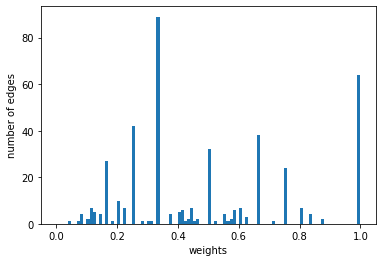

In [226]:
# Distribution of edge weights
plt.figure()
plt.hist(edge_list['weight'], bins=np.arange(0,1.01,0.01))
plt.xlabel('weights')
plt.ylabel('number of edges')
plt.show()

In [235]:
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome network')

# Set layout
net.hrepulsion(node_distance=200,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

# Import NetworkX graph
from_nx(G, net, default_node_size=20, 
        default_edge_weight=1,edge_weight_scale=0.1, edge_color_scale=1, edge_threshold=0.5, 
        hidden_edges=['MAZ','CTCF','BRD4','POLR2A','MAX'],
        shape='box')
#net.show_buttons()
net.show("adhesome_network.html")

# Helper functions

In [212]:
def format_node_label(raw_label):
    '''
    Function to put node label in a square format
    Args:
        raw_label: (Numpy array) array of gene names
    Returns:
        The formatted label (a string)
    '''
    label = raw_label.copy()   
    # Line breaks
    for i in range(1, len(labels)//2+1):
        if 2*i<len(label):
            label[2*i-1] = label[2*i-1]+' \n '
    label = ' '.join(label)
    return label

In [230]:
def from_nx(graph, pyvisnet, default_node_size=1, 
            default_edge_weight=1, edge_weight_scale=1, edge_color_scale=1, edge_threshold=0, hidden_edges=[], 
            shape='circle'):
    """
    This method takes an exisitng Networkx graph and translates
    it to a PyVis graph format that can be accepted by the VisJs
    API in the Jinja2 template. This operation is done in place.
    """
    nx_graph = graph.copy()
    assert(isinstance(nx_graph, nx.Graph))
    edges = nx_graph.edges(data=True)
    nodes = nx_graph.nodes(data=True)

    if len(edges) > 0:
        for e in edges:
            # Specify node size
            if 'size' not in nodes[e[0]].keys():
                nodes[e[0]]['size'] = default_node_size
            nodes[e[0]]['size'] = int(nodes[e[0]]['size'])
            if 'size' not in nodes[e[1]].keys():
                nodes[e[1]]['size'] = default_node_size
            nodes[e[1]]['size'] = int(nodes[e[1]]['size'])
            # Specify node color
            if nodes[e[0]]['n_TFs']>0:
                nodes[e[0]]['color'] = 'lightcoral'
            else:
                nodes[e[0]]['color'] = 'dodgerblue'
            if nodes[e[1]]['n_TFs']>0:
                nodes[e[1]]['color'] = 'lightcoral'
            else:
                nodes[e[1]]['color'] = 'dodgerblue'
            # Specify node title
            if len(nodes[e[0]]['all_TFs'])>0:
                nodes[e[0]]['title'] = 'adhesome: '+','.join(nodes[e[0]]['all_adhesomes'])+' / '+'TFs: '+','.join(nodes[e[0]]['all_TFs'])
            else:
                nodes[e[0]]['title'] = 'adhesome: '+','.join(nodes[e[0]]['all_adhesomes'])+' / '+'no TF'
            if nodes[e[1]]['n_TFs']>0:
                nodes[e[1]]['title'] = 'adhesome: '+','.join(nodes[e[1]]['all_adhesomes'])+' / '+'TFs: '+','.join(nodes[e[1]]['all_TFs'])
            else:
                nodes[e[1]]['title'] = 'adhesome: '+','.join(nodes[e[1]]['all_adhesomes'])+' / '+'no TF'
            pyvisnet.add_node(e[0], **nodes[e[0]], shape=shape)
            pyvisnet.add_node(e[1], **nodes[e[1]], shape=shape)

            if 'weight' not in e[2].keys():
                e[2]['weight'] = default_edge_weight
            edge_dict = e[2].copy()
            edge_dict["value"] = e[2]['weight']*edge_weight_scale
            edge_dict["title"] = 'TF: '+e[2]['TFs']+'\n'+'val: '+str(e[2]['weight'])
            edge_dict["color"] = colfunc(e[2]['weight']*edge_color_scale)
            edge_dict["arrowStrikethrough"] = False
            if (e[2]['weight']>edge_threshold) and (e[2]['TFs'] not in hidden_edges):
                pyvisnet.add_edge(e[0], e[1], **edge_dict)

    for node in nx.isolates(nx_graph):
        if 'size' not in nodes[node].keys():
            nodes[node]['size']=default_node_size
        pyvisnet.add_node(node, **nodes[node], shape=shape)

In [128]:
def colfunc(val, minval=0, maxval=1):
    """ Convert value in the range minval...maxval to a color in the range
        startcolor to stopcolor. The colors passed and the one returned are
        composed of a sequence of N component values (e.g. RGB).
    """
    RED, YELLOW, GREEN  = (1, 0, 0), (1, 1, 0), (0, 1, 0)
    CYAN, BLUE, MAGENTA = (0, 1, 1), (0, 0, 1), (1, 0, 1)
    WHITE = (1, 1, 1)
    f = float(val-minval) / (maxval-minval)
    return mpl.colors.rgb2hex(tuple(f*(b-a)+a for (a, b) in zip(WHITE, RED)))